In [1]:
# run this cell to setup matplotlib, and also import the very important take_picture function from camera!
%matplotlib notebook
import matplotlib.pyplot as plt
from camera import take_picture
import numpy as np
import cv2

In [2]:
from facenet_models import FacenetModel

# this will download the pretrained weights for MTCNN and resnet
# (if they haven't already been fetched)
# which should take just a few seconds
model = FacenetModel()

## Importing Face 1

pic shape: (562, 450, 3)


<IPython.core.display.Javascript object>


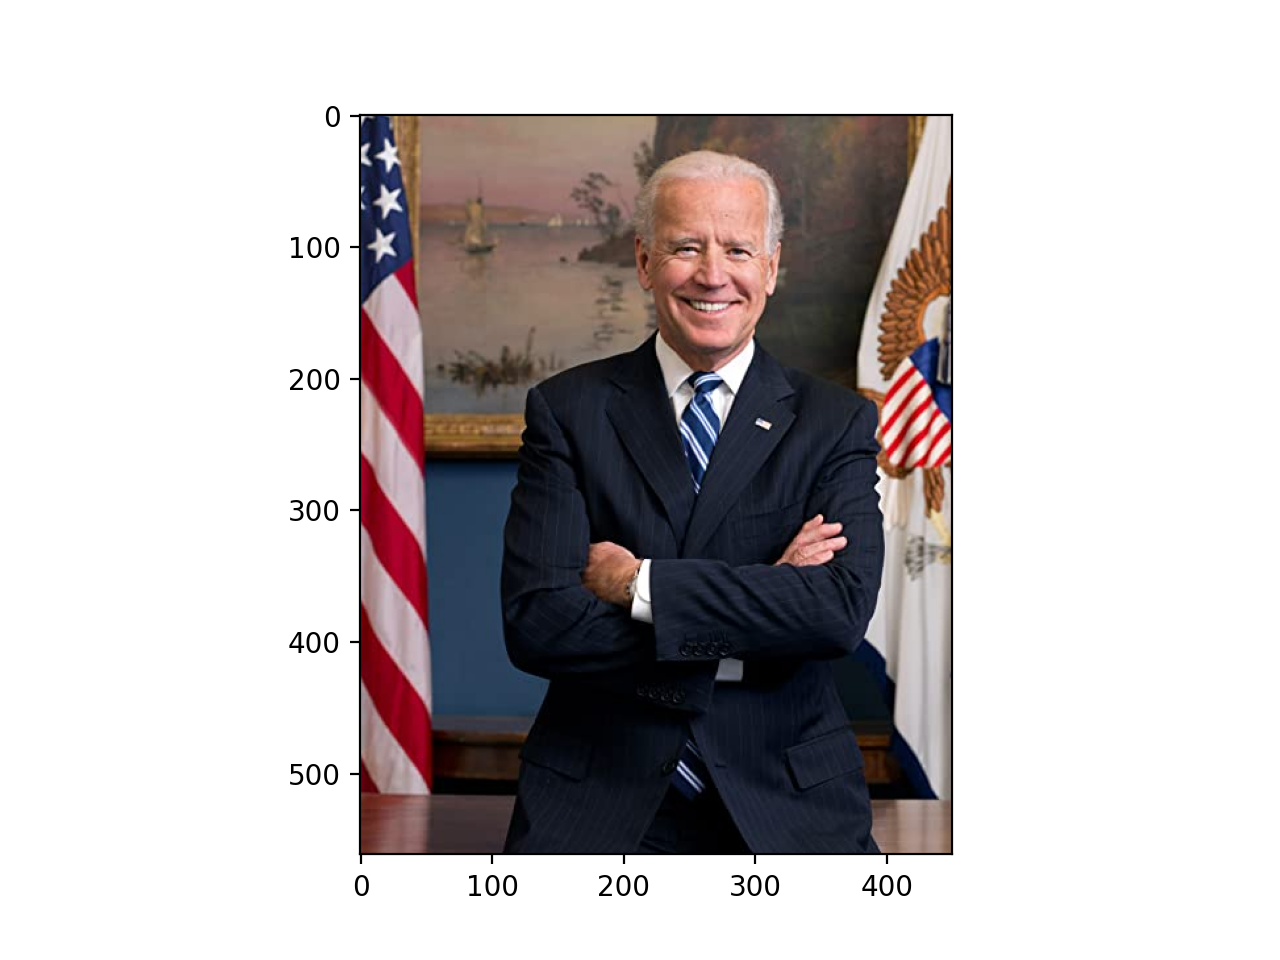

In [3]:
pic = cv2.imread("database/JB/10.jpg")[:,:,::-1] # The slicing part converts the BGR image to RGB
#cv2.imshow("test", pic) # Will have a window pop-up of the image. Press any key to continue
#cv2.waitKey(0)
#cv2.destroyAl|lWindows()
print("pic shape:", pic.shape)
plt.imshow(pic)

In [4]:
# detect all faces in an image
# returns a tuple of (boxes, probabilities, landmarks)
# assumes ``pic`` is a numpy array of shape (R, C, 3) (RGB is the last dimension)
#
# If N faces are detected then arrays of N boxes, N probabilities, and N landmark-sets
# are returned.
boxes, probabilities, landmarks = model.detect(pic)

print(f"Number of faces detected: {len(boxes)}")
print("Probabilities:", probabilities)

/Users/ssharma/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Number of faces detected: 1
Probabilities: [0.9999101]


<IPython.core.display.Javascript object>


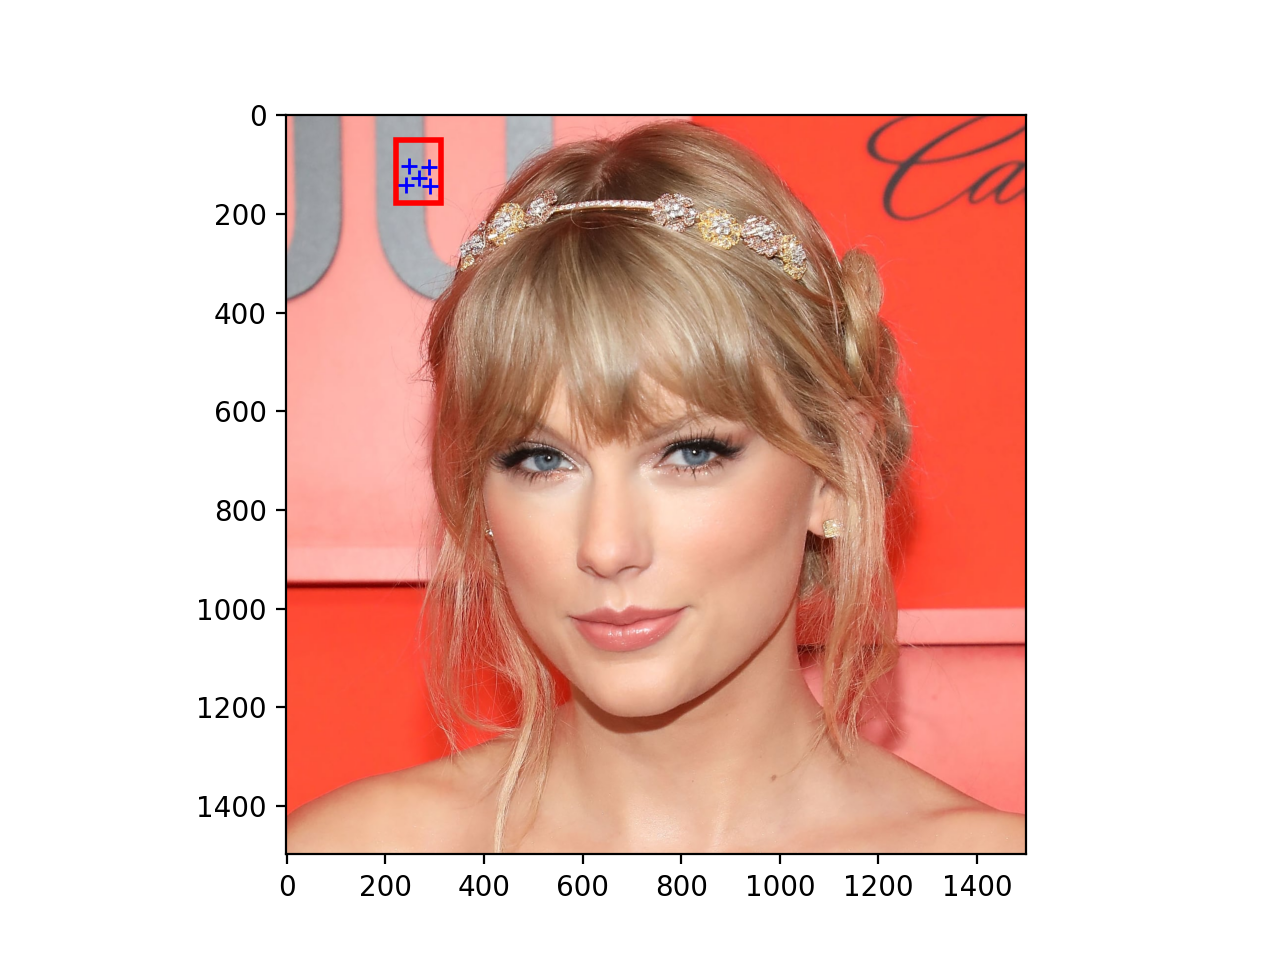

In [5]:
# SHOWING FACE RECTANGLES
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.imshow(pic)


for box, prob, landmark in zip(boxes, probabilities, landmarks):
    # draw the box on the screen
    ax.add_patch(Rectangle(box[:2], *(box[2:] - box[:2]), fill=None, lw=2, color="red"))

    # Get the landmarks/parts for the face in box d.
    # Draw the face landmarks on the screen.
    for i in range(len(landmark)):
        ax.plot(landmark[i, 0], landmark[i, 1], "+", color="blue")

In [6]:
# let's take a look as to what the descriptor is!!
descriptor = model.compute_descriptors(pic, boxes) # Producing the descriptor vector
descriptor = descriptor.reshape(512)
print(descriptor.shape)
#print(descriptor)

(512,)


## Importing Face 2

In [24]:
pic2 = cv2.imread("database/TS/2.jpg")[:,:,::-1] # The slicing part converts the BGR image to RGB
#cv2.imshow("test", pic) # Will have a window pop-up of the image. Press any key to continue
#cv2.waitKey(0)
#cv2.destroyAllWindows()
print("pic2 shape:", pic2.shape)
plt.imshow(pic2)

pic2 shape: (3310, 2203, 3)


In [25]:
# detect all faces in an image
# returns a tuple of (boxes, probabilities, landmarks)
# assumes ``pic`` is a numpy array of shape (R, C, 3) (RGB is the last dimension)
#
# If N faces are detected then arrays of N boxes, N probabilities, and N landmark-sets
# are returned.
boxes2, probabilities2, landmarks2 = model.detect(pic2)

print(f"Number of faces detected: {len(boxes2)}")
print("Probabilities:", probabilities2)

Number of faces detected: 3
Probabilities: [0.99992347 0.9564824  0.7479574 ]


<IPython.core.display.Javascript object>


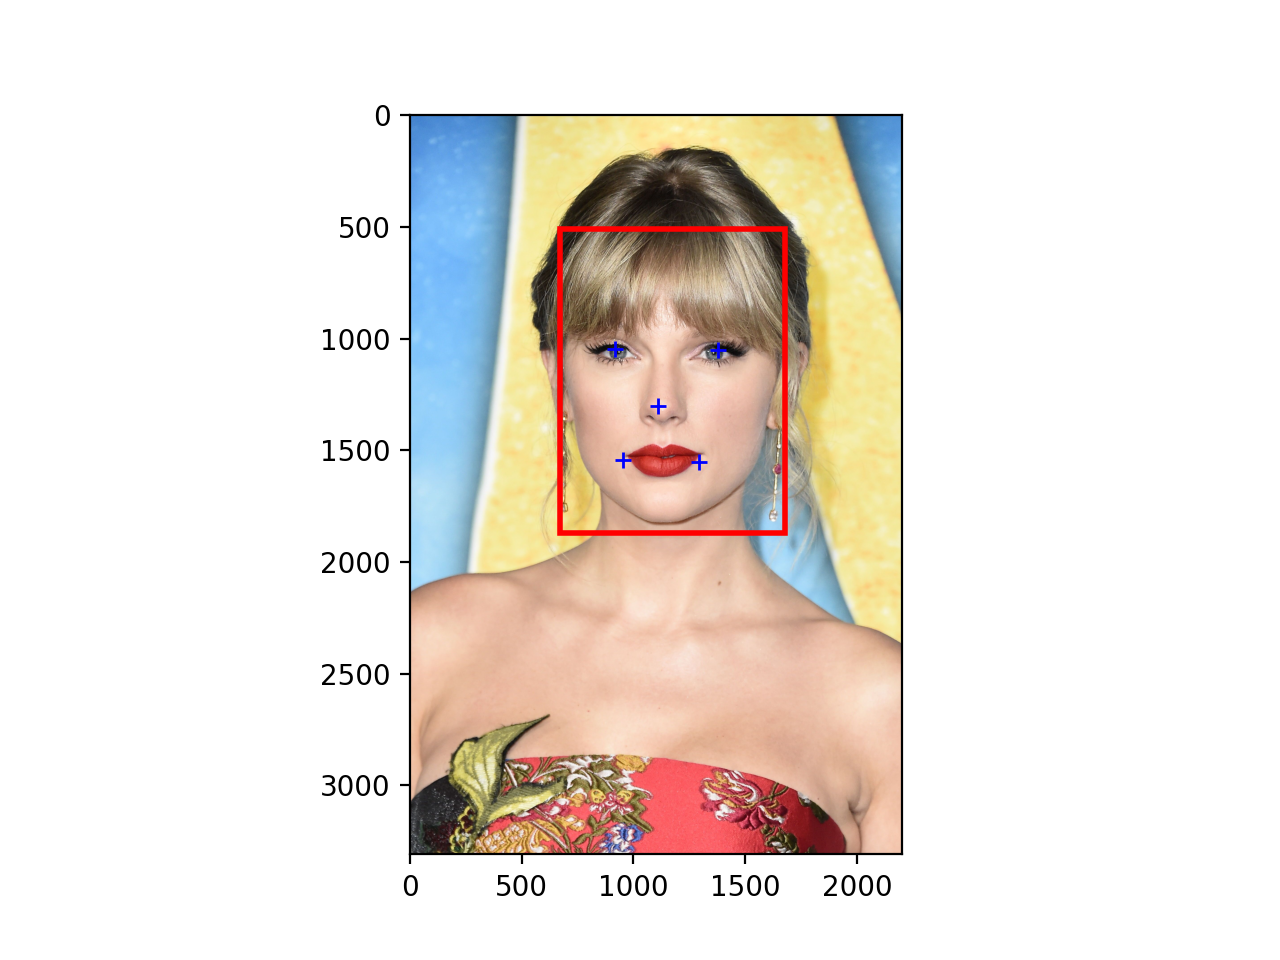

In [27]:
# SHOWING FACE RECTANGLES
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()
ax.imshow(pic2)


for box, prob, landmark in zip(boxes2[:1], probabilities2[:1], landmarks2[:1]):
    # draw the box on the screen
    ax.add_patch(Rectangle(box[:2], *(box[2:] - box[:2]), fill=None, lw=2, color="red"))

    # Get the landmarks/parts for the face in box d.
    # Draw the face landmarks on the screen.
    for i in range(len(landmark)):
        ax.plot(landmark[i, 0], landmark[i, 1], "+", color="blue")

In [10]:
# let's take a look as to what the descriptor is!!
descriptor2 = model.compute_descriptors(pic2, boxes2) # Producing the descriptor vector
descriptor2 = descriptor2.reshape(512)
print(descriptor2.shape)
#print(descriptor)

(512,)


## Comparing the two faces

In [11]:
import numpy as np
import mygrad as mg

In [12]:
def cos_distance(d_avg, d_test):
    d_avg_normalized = d_avg / np.linalg.norm(d_avg)
    d_test_normalized = d_test / np.linalg.norm(d_test)
    
    # print(d_avg_normalized)
    # print(d_test_normalized)
    
    numerator = np.dot(d_avg_normalized, d_test_normalized)
    d_avg_mag = np.sqrt(np.dot(d_avg_normalized, d_avg_normalized))
    d_test_mag = np.sqrt(np.dot(d_test_normalized, d_test_normalized))
    
    return 1 - numerator # / (d_avg_mag * d_test_mag)

In [13]:
cos_dist = cos_distance(descriptor, descriptor2)
print(cos_dist)

1.0762397199869156


In [91]:
import numpy as np
from typing import List

import networkx as nx
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


class Node:
    """ Describes a node in a graph, and the edges connected
        to that node."""

    def __init__(self, ID, neighbors, descriptor, truth=None, file_path=None):
        """
        Parameters
        ----------
        ID : int
            A unique identifier for this node. Should be a
            value in [0, N-1], if there are N nodes in total.

        neighbors : Sequence[int]
            The node-IDs of the neighbors of this node.

        descriptor : numpy.ndarray
            The shape-(512,) descriptor vector for the face that this node corresponds to.

        truth : Optional[str]
            If you have truth data, for checking your clustering algorithm,
            you can include the label to check your clusters at the end.
            If this node corresponds to a picture of Ryan, this truth
            value can just be "Ryan"

        file_path : Optional[str]
            The file path of the image corresponding to this node, so
            that you can sort the photos after you run your clustering
            algorithm
        """
        self.id = ID  # a unique identified for this node - this should never change

        # The node's label is initialized with the node's ID value at first,
        # this label is then updated during the whispers algorithm
        self.label = ID

        # (n1_ID, n2_ID, ...)
        # The IDs of this nodes neighbors. Empty if no neighbors
        self.neighbors = tuple(neighbors)
        self.descriptor = descriptor

        self.truth = truth
        self.file_path = file_path


def plot_graph(graph, adj):
    """ Use the package networkx to produce a diagrammatic plot of the graph, with
    the nodes in the graph colored according to their current labels.
    Note that only 20 unique colors are available for the current color map,
    so common colors across nodes may be coincidental.
    Parameters
    ----------
    graph : Tuple[Node, ...]
        The graph to plot. This is simple a tuple of the nodes in the graph.
        Each element should be an instance of the `Node`-class.

    adj : numpy.ndarray, shape=(N, N)
        The adjacency-matrix for the graph. Nonzero entries indicate
        the presence of edges.

    Returns
    -------
    Tuple[matplotlib.fig.Fig, matplotlib.axis.Axes]
        The figure and axes for the plot."""

    g = nx.Graph()
    for n, node in enumerate(graph):
        g.add_node(n)

    # construct a network-x graph from the adjacency matrix: a non-zero entry at adj[i, j]
    # indicates that an egde is present between Node-i and Node-j. Because the edges are
    # undirected, the adjacency matrix must be symmetric, thus we only look ate the triangular
    # upper-half of the entries to avoid adding redundant nodes/edges
    g.add_edges_from(zip(*np.where(np.triu(adj) > 0)))

    # we want to visualize our graph of nodes and edges; to give the graph a spatial representation,
    # we treat each node as a point in 2D space, and edges like compressed springs. We simulate
    # all of these springs decompressing (relaxing) to naturally space out the nodes of the graph
    # this will hopefully give us a sensible (x, y) for each node, so that our graph is given
    # a reasonable visual depiction
    pos = nx.spring_layout(g)

    # make a mapping that maps: node-lab -> color, for each unique label in the graph
    color = list(iter(cm.tab20b(np.linspace(0, 1, len(set(i.label for i in graph))))))
    color_map = dict(zip(sorted(set(i.label for i in graph)), color))
    colors = [color_map[i.label] for i in graph]  # the color for each node in the graph, according to the node's label

    # render the visualization of the graph, with the nodes colored based on their labels!
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(g, pos=pos, ax=ax, nodelist=range(len(graph)), node_color=colors)
    nx.draw_networkx_edges(g, pos, ax=ax, edgelist=g.edges())
    return fig, ax

def whispers_algorithm(adj_matrix: np.ndarray, nodes: List[Node]):
    '''
    adj_matrix: an adjacency matrix that consists of all images (N x N). This is
    used for the weighted sum.
    
    nodes: a list of Node objects. This is used to determine if a node has been visited
    and also allows us to change the label of a node and access its neighbors.
    '''
    N = len(nodes)
    visited = {}
    while len(visited) < N:
        i = np.random.randint(0, N, size=1)[0]
        node = nodes[i]
        if node.id not in visited:
            weighted_sum_list = {}
            for i in node.neighbors:
                neighbor = nodes[i]
                if neighbor.label not in weighted_sum_list:
                    weighted_sum_list[neighbor.label] = adj_matrix[node.id][neighbor.id]
                else:
                    weighted_sum_list[neighbor.label] += adj_matrix[node.id][neighbor.id]
            if weighted_sum_list:
                max_weighted_sum = weighted_sum_list[max(weighted_sum_list, key=weighted_sum_list.get)]
                potential_neighbors = [k for k,v in weighted_sum_list.items() if v == max_weighted_sum]
                if potential_neighbors:
                    r = np.random.randint(0, len(potential_neighbors), size=1)[0]
                    label = nodes[potential_neighbors[r]].label
            
                    node.label = label
            visited[node.id] = True

def assess_success(nodes):
    correct_match = 0
    label_match_only = 0
    truth_match_only = 0
    
    for node_i in range(len(nodes)):
        if node_i + 1 < len(nodes):
            if nodes[node_i].label ==nodes[node_i + 1].label and nodes[node_i].truth == nodes[node_i + 1].truth: 
                correct_match += 1
            elif not nodes[node_i].label == nodes[node_i + 1].label and nodes[node_i].truth == nodes[node_i + 1].truth:
                truth_match_only += 1
            elif nodes[node_i].label == nodes[node_i + 1].label and not nodes[node_i].truth == nodes[node_i + 1].truth:
                label_match_only += 1
            else: 
                break
    
    pairwise_precision = correct_match / (correct_match + truth_match_only)
    pairwise_recall = correct_match / (correct_match + label_match_only)
    return pairwise_precision, pairwise_recall

In [133]:
import os

descriptors_list = []

for directory in os.listdir('database'):
    directory_to_read = 'database/' + directory
    for file in os.listdir(directory_to_read):
        print(directory_to_read + '/' + file)
        pic = cv2.imread(directory_to_read + '/' + file)[:,:,::-1]
        boxes, probabilities, _ = model.detect(pic)
        box = [boxes[np.argmax(probabilities)]]
        descriptor = model.compute_descriptors(pic, box) # Producing the descriptor vector
        descriptor = descriptor.reshape(512)
        descriptors_list.append(descriptor)
# np.save('descriptors.npy', np.array(descriptors_list))

database/SO/4.jpg
database/SO/5.png
database/SO/2.jpg
database/SO/3.jpg
database/SO/1.png
database/BS/4.jpg
database/BS/5.jpg
database/BS/6.jpg
database/BS/2.jpg
database/BS/3.jpg
database/BS/1.jpg
database/JB/8.jpg
database/JB/9.jpg
database/JB/11.jpg
database/JB/10.jpg
database/JB/4.jpg
database/JB/5.jpg
database/JB/7.jpg
database/JB/6.jpg
database/JB/2.jpg
database/JB/3.jpg
database/JB/1.jpg
database/TS/4.jpg
database/TS/5.jpg
database/TS/2.jpg
database/TS/3.jpg
database/TS/1.jpg
database/WS/4.jpg
database/WS/5.jpg
database/WS/2.jpg
database/WS/3.jpg
database/WS/1.jpg


In [134]:
cos_distances = []

for i in range(0, len(descriptors_list)):
    for k in range(i+1, len(descriptors_list)):
        dist = cos_distance(descriptors_list[i], descriptors_list[k])
        cos_distances.append(dist)
cos_distances

[0.19441771507263184,
 0.26582860946655273,
 0.20847761631011963,
 0.1660604476928711,
 1.124073438346386,
 1.1274051368236542,
 1.2339448630809784,
 1.2088148146867752,
 0.9491531401872635,
 1.1204164773225784,
 0.9234204664826393,
 0.9338195323944092,
 1.083653874695301,
 1.0262570530176163,
 0.9636566266417503,
 0.9756743777543306,
 0.9690871685743332,
 1.0242267660796642,
 0.9646757766604424,
 0.953826155513525,
 1.0079895788803697,
 0.950213149189949,
 0.8586895763874054,
 0.7723268866539001,
 0.8841517716646194,
 0.9160988703370094,
 0.9861911470070481,
 0.9432165063917637,
 1.0275091286748648,
 0.9200546443462372,
 0.9402275793254375,
 0.32005834579467773,
 0.20314180850982666,
 0.19610023498535156,
 1.0377610921859741,
 1.07676962018013,
 1.174646258354187,
 1.1717328131198883,
 0.8673430532217026,
 1.0388677902519703,
 0.8997709825634956,
 0.9112273901700974,
 1.0146594755351543,
 0.9089194387197495,
 0.8865311443805695,
 0.9194250851869583,
 0.9032770469784737,
 0.94880181178

In [72]:
cos_distances = np.array(cos_distances)
cos_distances.min(), cos_distances.max()

(0.07449209690093994, 1.3585636019706726)

<IPython.core.display.Javascript object>


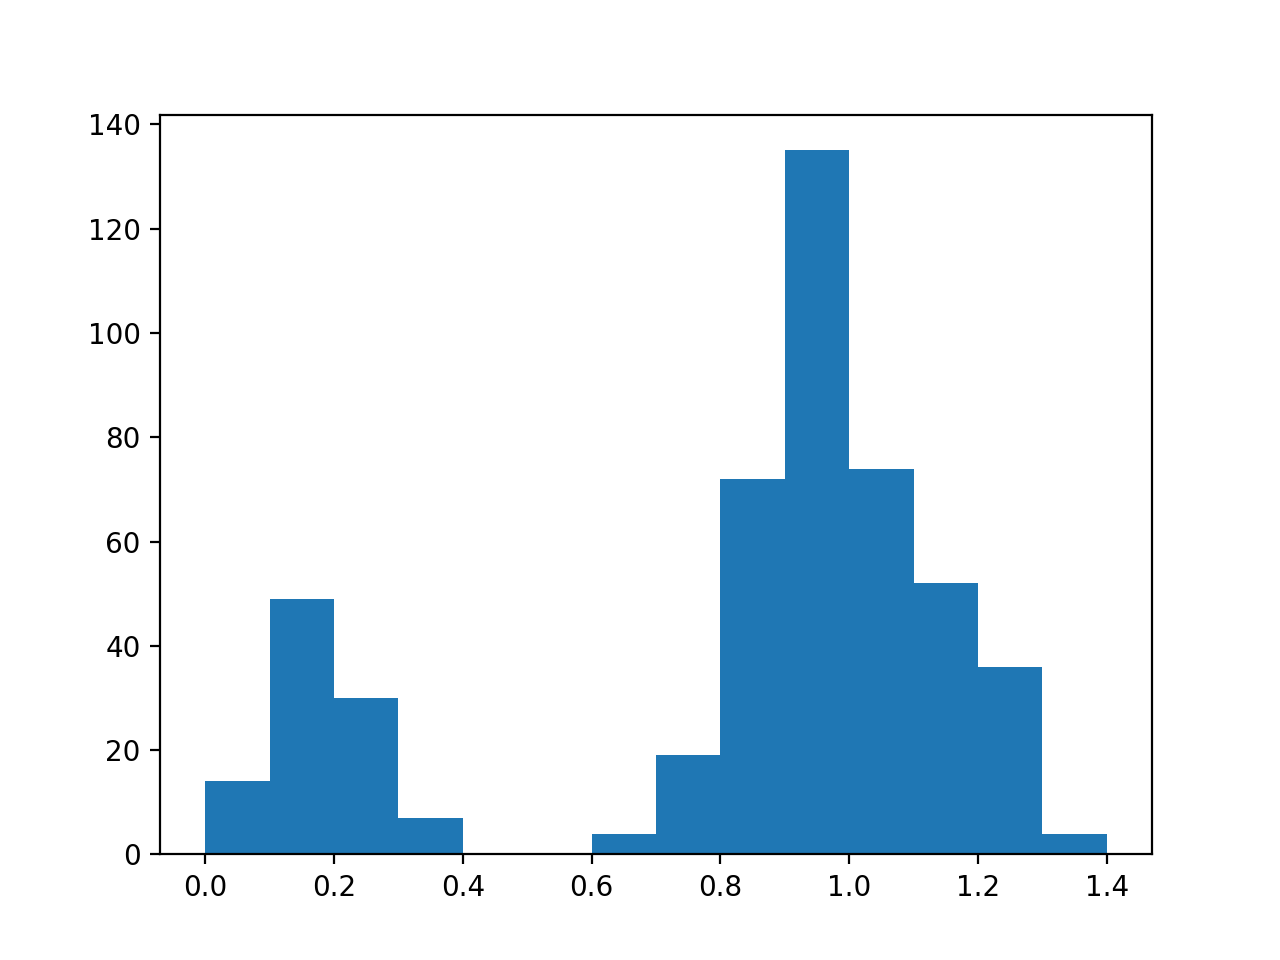

(array([ 14.,  49.,  30.,   7.,   0.,   0.,   4.,  19.,  72., 135.,  74.,
         52.,  36.,   4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4]),
 <BarContainer object of 14 artists>)

In [135]:
classes_labels = np.arange(0, 1.5, 0.1)

fig, ax = plt.subplots()
ax.hist(cos_distances, bins=classes_labels)

In [139]:
def create_graph(descriptors_list, threshold):
    N = len(descriptors_list)
    nodes = []
    adj_matrix = np.zeros(shape=(N, N))

    for i in range(N):
        for k in range(i+1, N):
            dist = cos_distance(descriptors_list[i], descriptors_list[k])
            if dist < threshold:
                adj_matrix[i][k] = 1 / (dist**2)
                adj_matrix[k][i] = 1 / (dist**2)

    for i in range(N):
        neighbors = []
        for k in range(N):
            if adj_matrix[i][k] > 0:
                neighbors.append(k)
        truth = None
        if i >= 0 and i <= 10:
            truth = 'JB'
        elif i >= 11 and i <= 15:
            truth = 'TS'
        elif i >= 16 and i <= 20:
            truth = 'BS'
        u = Node(i, neighbors, descriptors_list[i], truth)
        nodes.append(u)
    return (adj_matrix, nodes)

adj_matrix, nodes = create_graph(descriptors_list, 0.6)
whispers_algorithm(adj_matrix, nodes)
for node in nodes:
    print(node.label)
pairwise_precision, pairwise_recall = assess_success(nodes)
print('precision: {}; recall: {}'.format(pairwise_precision, pairwise_recall))

0
0
0
4
0
6
6
6
6
6
6
15
15
15
15
15
15
15
15
15
15
15
25
25
25
25
25
31
31
31
31
31
precision: 0.7; recall: 1.0


<IPython.core.display.Javascript object>


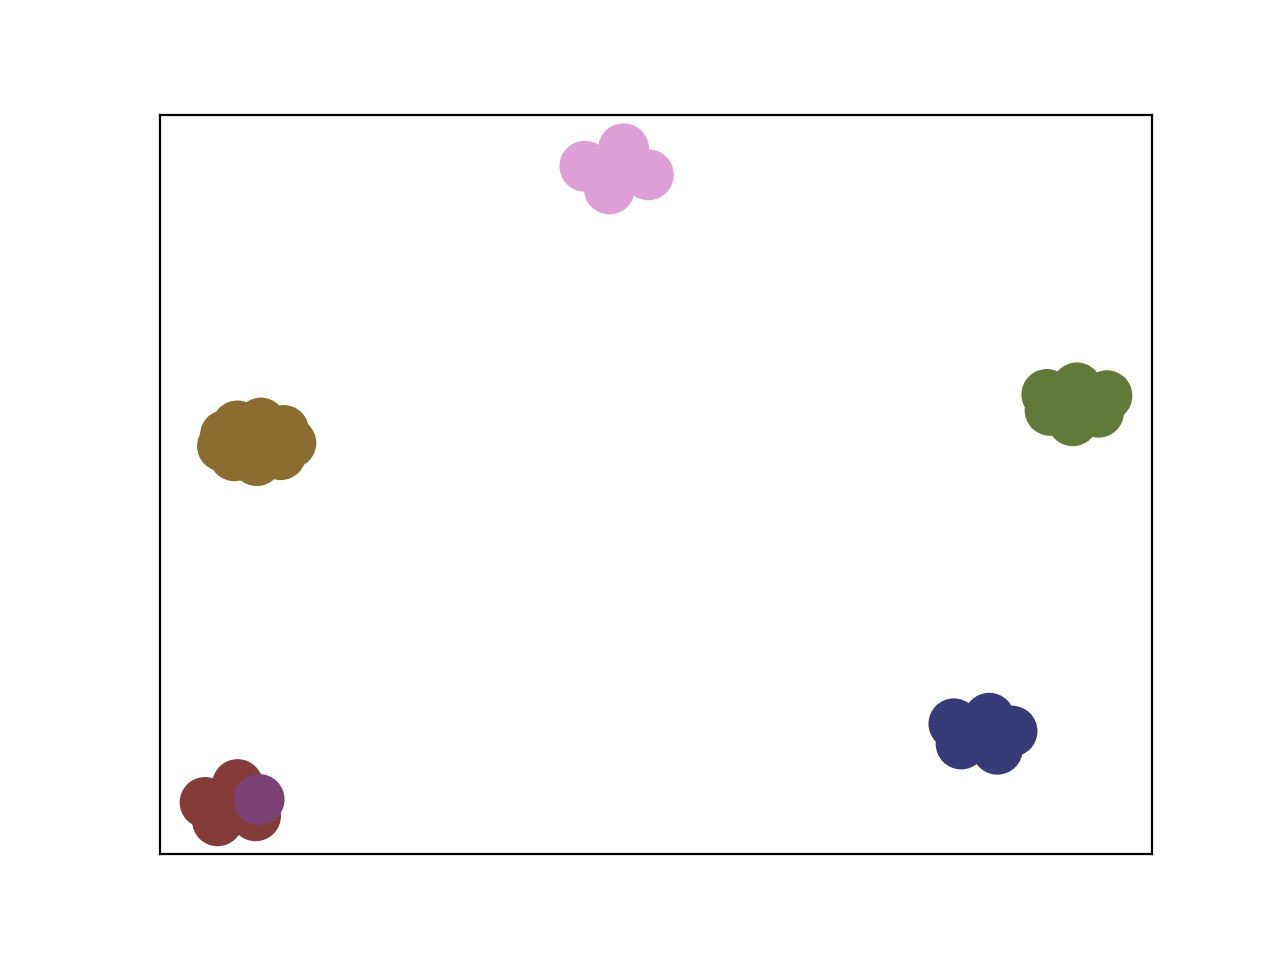

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [137]:
plot_graph(tuple(nodes), adj_matrix)